# 客户分配问题

## 目标和前提条件

通过这个示例提高您的数学优化建模技能。在本例中，您将学习如何基于客户的位置来选择设施的位置。我们将演示如何使用Gurobi Python API构建此设施选址问题的混合整数规划(MIP)模型，并使用Gurobi优化器生成最优解。

这是一个中级建模示例，我们假设您了解Python并熟悉Gurobi Python API。此外，您还应该对构建数学优化模型有一定的了解。

**下载仓库** <br />
您可以通过点击[这里](https://github.com/Gurobi/modeling-examples/archive/master.zip)下载包含此示例和其他示例的代码仓库。

---
## 动机

各行各业的许多公司在某个时候都必须做出战略决策，即在何处建设设施以支持其运营。例如：

- 商品生产商需要决定如何设计其供应链 – 包括工厂、配送中心、仓库和零售店。
- 医疗保健提供者需要确定在何处建设医院以最大限度地覆盖人口。

这些都是难以实施且代价高昂的战略决策，因为它们涉及长期投资。此外，这些决策具有重大影响，无论是在客户满意度还是成本管理方面。在这个过程中要考虑的一个关键因素是公司计划服务的客户的位置。

---
## 问题描述

客户分配问题与设施选址问题密切相关，后者关注如何在一组候选位置中最优地放置设施，以最小化公司设施与客户之间的距离。当设施具有无限容量时，假设客户由最近的设施服务。

在客户数量太大的情况下，可以将客户分组为簇。然后，可以使用簇中心代替单个客户位置。这种预处理假设属于给定簇的所有客户都将由分配给该簇的设施服务。k-means算法可用于此任务，该算法旨在将$n$个对象划分为$k$个不同且不重叠的簇。

---
## 解决方案方法

数学优化是一种声明性方法，其中建模者制定一个数学优化模型，该模型捕获复杂决策问题的关键方面。Gurobi优化器使用最先进的数学和计算机科学来求解这些模型。

数学优化模型有五个组成部分，即：

- 集合和索引
- 参数
- 决策变量
- 目标函数
- 约束条件

现在我们提出一个二元整数规划(BIP)表达式：

### 集合和索引
$i \in I$: 客户簇的集合

$j \in J$: 潜在设施位置的集合

$\text{Pairings}= \{(i,j) \in I \times J: \text{dist}_{i,j} \leq \text{threshold}\}$: 允许的配对集合

### 参数
$\text{threshold} \in \mathbb{R}^+$: 簇-设施配对要考虑的最大距离

$\text{max_facilities} \in \mathbb{N}$: 要开设的最大设施数量

$\text{weight}_i \in \mathbb{N}$: 簇$i$中的客户数量

$\text{dist}_{i,j} \in \mathbb{R}^+$: 从簇$i$到设施位置$j$的距离

### 决策变量
$\text{select}_j \in \{0,1\}$: 如果选择设施位置$j$则为1；否则为0

$\text{assign}_{i,j} \in \{0,1\}$: 如果簇$i$被分配给设施位置$j$则为1；否则为0

### 目标函数

- **总距离**: 最小化从簇到其分配设施的总距离：

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Pairings}}\text{weight}_i \cdot \text{dist}_{i,j} \cdot \text{assign}_{i,j}
\tag{0}
\end{equation}

### 约束条件

- **设施限制**: 建设的设施数量不能超过限制：

\begin{equation}
\sum_{j}\text{select}_j \leq \text{max_facilities}
\tag{1}
\end{equation}

- **开放分配**: 簇$i$只能分配给我们决定建设的设施$j$：

\begin{equation}
\text{assign}_{i,j} \leq \text{select}_{j} \quad \forall (i,j) \in \text{Pairings}
\tag{2}
\end{equation}

- **最近设施**: 簇$i$必须恰好分配给一个设施：

\begin{equation}
\sum_{j:(i,j) \in \text{Pairings}}\text{assign}_{i,j} = 1 \quad \forall i \in I
\tag{3}
\end{equation}

---
## Python实现

### 数据集生成

在这个简单的示例中，我们为客户和设施候选位置选择随机位置。客户使用高斯分布分布在几个随机选择的人口中心周围，而设施位置则均匀分布。

In [ ]:
# %pip install gurobipy

In [1]:
%matplotlib inline
import random

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans

# 使用 Gurobi v9.0.0 和 Python 3.7.0 测试

seed = 10101
num_customers = 50000
num_candidates = 20
max_facilities = 8
num_clusters = 50
num_gaussians = 10
threshold = 0.99

random.seed(seed)
customers_per_gaussian = np.random.multinomial(num_customers,
                                               [1/num_gaussians]*num_gaussians)
customer_locs = []
for i in range(num_gaussians):
    # 每个中心坐标在 [-0.5, 0.5] 范围内
    center = (random.random()-0.5, random.random()-0.5)
    customer_locs += [(random.gauss(0,.1) + center[0], random.gauss(0,.1) + center[1])
                  for i in range(customers_per_gaussian[i])]
# 每个候选点坐标在 [-0.5, 0.5] 范围内
facility_locs = [(random.random()-0.5, random.random()-0.5)
              for i in range(num_candidates)]
print('第一个客户位置:', customer_locs[0])

第一个客户位置: (0.33164437091949245, -0.2809884943538464)


### 预处理
**聚类**

为了限制优化模型的规模，我们将个体客户分组为簇，并对这些簇进行优化。使用scikit-learn包中实现的K-means算法来计算簇。

In [2]:
kmeans = MiniBatchKMeans(n_clusters=num_clusters, init_size=3*num_clusters,
                         random_state=seed).fit(customer_locs)
memberships = list(kmeans.labels_)
centroids = list(kmeans.cluster_centers_) # 每个簇的中心点
weights = list(np.histogram(memberships, bins=num_clusters)[0]) # 每个簇中的客户数量
print('第一个簇中心:', centroids[0])
print('前10个簇的数量:', weights[:10])

第一个簇中心: [-0.20752964  0.24950336]
前10个簇的数量: [906, 1278, 965, 1008, 862, 1594, 1222, 1031, 1392, 730]


***可行的客户-设施配对***

有些设施离簇中心太远而无关紧要，所以让我们启发式地过滤掉所有超过给定`threshold`的距离：

In [3]:
def dist(loc1, loc2):
    return np.linalg.norm(loc1-loc2, ord=2) # 欧几里得距离

pairings = {(facility, cluster): dist(facility_locs[facility], centroids[cluster])
            for facility in range(num_candidates)
            for cluster in range(num_clusters) 
            if  dist(facility_locs[facility], centroids[cluster]) < threshold}
print("可行配对数量: {0}".format(len(pairings.keys())))

可行配对数量: 951


### 模型部署

从候选位置中建设设施，以最小化到簇中心的总距离：

In [4]:
m = gp.Model("设施选址")

# 决策变量：选择设施位置
select = m.addVars(range(num_candidates), vtype=GRB.BINARY, name='select')
# 决策变量：将客户簇分配给设施位置
assign = m.addVars(pairings.keys(), vtype=GRB.BINARY, name='assign')

# 部署目标函数
# 0. 总距离
obj = gp.quicksum(weights[cluster]
               *pairings[facility, cluster]
               *assign[facility, cluster]
               for facility, cluster in pairings.keys())
m.setObjective(obj, GRB.MINIMIZE)

# 1. 设施限制
m.addConstr(select.sum() <= max_facilities, name="设施限制")

# 2. 开放分配
m.addConstrs((assign[facility, cluster] <= select[facility]
             for facility, cluster in pairings.keys()),
            name="开放分配")

# 3. 最近商店
m.addConstrs((assign.sum('*', cluster) == 1
             for cluster in range(num_clusters)),
            name="最近商店")

# 寻找最优解
m.optimize()

Set parameter LicenseID to value 2601452
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Optimize a model with 1002 rows, 971 columns and 2873 nonzeros
Model fingerprint: 0x6980596a
Variable types: 0 continuous, 971 integer (971 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Presolve time: 0.01s
Presolved: 1002 rows, 971 columns, 2873 nonzeros
Variable types: 0 continuous, 971 integer (971 binary)
Found heuristic solution: objective 8189.9719339

Root relaxation: objective 7.088351e+03, 110 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

## 分析

让我们绘制一张地图，包含：

- 用小粉红点表示客户位置
- 用大红点表示客户簇中心
- 用绿点表示设施位置候选点。注意，被选中的位置会有黑线从它们延伸到每个可能由该设施服务的簇。

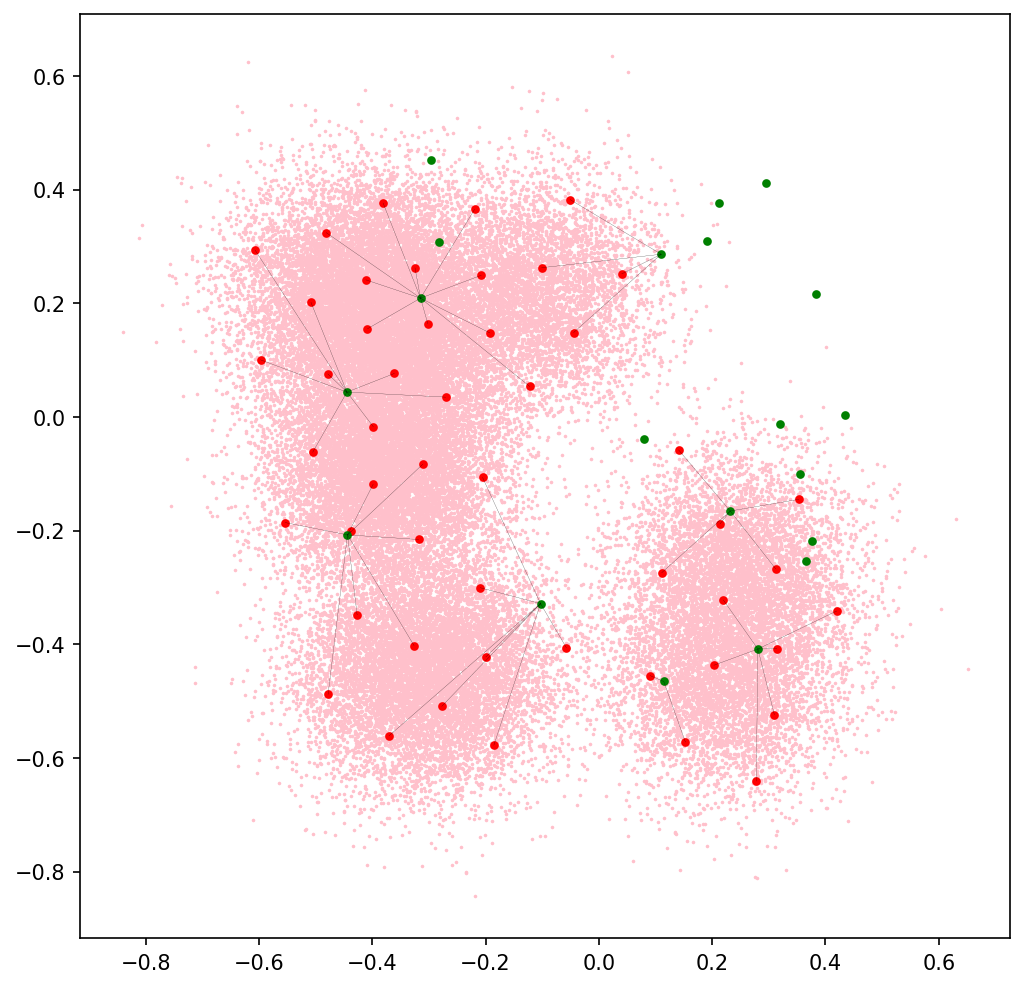

In [5]:
plt.figure(figsize=(8,8), dpi=150)
plt.scatter(*zip(*customer_locs), c='Pink', s=0.5)
plt.scatter(*zip(*centroids), c='Red', s=10)
plt.scatter(*zip(*facility_locs), c='Green', s=10)
assignments = [p for p in pairings if assign[p].x > 0.5]
for p in assignments:
    pts = [facility_locs[p[0]], centroids[p[1]]]
    plt.plot(*zip(*pts), c='Black', linewidth=0.1)

In [6]:
m.dispose()
gp.disposeDefaultEnv()

Freeing default Gurobi environment


---
## 结论

我们学习了如何使用数学优化来解决客户分配问题。此外，还展示了如何在预处理中使用机器学习来减少大数据集的计算负担。当然，这是有代价的，因为使用较少的簇会导致对全局最优解的粗略近似。

---
## 参考文献

1. Drezner, Z., & Hamacher, H. W. (Eds.). (2001). Facility location: applications and theory. Springer Science & Business Media.
2. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.
3. Klose, A., & Drexl, A. (2005). Facility location models for distribution system design. European journal of operational research, 162(1), 4-29.

Copyright © 2020 Gurobi Optimization, LLC